In [70]:
import numpy as np
from numpy import average
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from PIL import Image, ImageOps

In [71]:
path = 'a.npy'
pathForBias = 'aBias.npy'
def SaveWeigthsInFile(path, network):
  np.save(path, network.BestWeights)

def SaveBiasWeightsInFile(path, network):
  np.save(path, network.BestBiasWeights)

def ReadWeigthFromFile(path):
  return np.load(path,allow_pickle=True)

In [72]:
def approximationFunc(x):
    return np.power(x,2)*np.exp(np.sin(x))

In [73]:
def sigmoid(x):
    #Сигмоидная функция активации: f(x) = 1 / (1 + e^(-x))
    return x / (1 + np.abs(x))
    #return 1 if x > 0 else 0

def dersigmoid(s):
  return 1 / (1 + np.abs(s))**2

def Hebb(weight, ny, x0, y, e):
    return weight - ny * x0 * (y - e)

In [74]:
'''Описание класса нейрона'''
class Neuron:
    def __init__(self, weights, bias =1, biasWigth = 1, knowingRatio = 0.9):
        self.Weights = weights
        self.DeltaWeights = np.zeros(len(weights))
        self.Bias = bias
        self.KnowingRatio = knowingRatio
        self.Beta = 0
        self.dW = 0
        self.dB = 0
        self.BiasWigth = biasWigth
    
    def feedforward(self, inputs):
        self.LastInput = inputs
        total = np.dot(self.Weights, inputs) + self.Bias * self.BiasWigth
        self.LastRezult = total
        return sigmoid(total)
    
    
    def WeightCorrection(self, lam):
      self.dW = self.KnowingRatio*self.dW + (1 - self.KnowingRatio) * np.square(self.Beta) 
      self.dB = self.KnowingRatio*self.dB + (1 - self.KnowingRatio) * np.square(self.Beta)
      
      self.Weights = self.Weights - np.dot(lam * self.Beta/(np.sqrt(self.dW) + 0.0001), self.LastInput)
      self.BiasWigth = self.BiasWigth - lam * self.Beta/(np.sqrt(self.dB) + 0.0001)
                

    

In [75]:
#Neuron network class

class HebbNetworkGradient:
    def __init__(self, neuronsCountArray,biasWeights = [], Weights = [],
                eps = 0.1, lam = 0.1, epochs = 20000, neuroneKnowingRatio = 0.9,
                 drawInfo = True, drawInfoEpochs = 1000):
        '''
        neuronsCountArray example [25, 14, 7, 3, 1] where each number mean
         a count of neurons in the layer
        ''' 
        self.IsDrawInfo = drawInfo
        self.DrawInfoEpochs = drawInfoEpochs

        self.Eps = eps
        self.T = 0
        self.Epochs = epochs
        self.Lam = lam
        self.BestWeights = []
        self.BestBiasWeights = []
        self.BestL = 10000000000
        self.L = []
        self.Neurons = {}
        for i in range(1, len(neuronsCountArray)):
          self.Neurons[i] = []
          if(len(Weights) == 0):
            for j in range(neuronsCountArray[i]):
              self.Neurons[i].append(Neuron(np.random.randint(-10,10,neuronsCountArray[i-1]), 1, knowingRatio=neuroneKnowingRatio)) 
          else:
            print(i)
            for j in range(len(Weights[i-1])):
              self.Neurons[i].append(Neuron(Weights[i-1][j], 1, biasWeights[i-1][j], knowingRatio=neuroneKnowingRatio))
    
    def fit(self, X, y):
        self.T = 1
        self.CalculateLoss(X,y)
        while self.L[len(self.L)-1] > self.Eps and self.T < self.Epochs:
            n_rule = np.random.randint(len(X))
            #for n_rule in range(len(X)):
            e = self.feedforward(X[n_rule])
            if any(np.abs(self.lossFunction(y[n_rule],e))) > self.Eps:
              #if np.argmax(y[n_rule]) != e.index(max(e)):
                  self.WeightCorrection(y[n_rule])
                  self.CalculateLoss(X,y)
                  self.T+=1
        print("network was learned for",self.T,"generations")
    
    def predict(self, data):
        y = []
        for i in data:
          y.append(self.feedforward(i))
        return y
        
    def feedforward(self, inputs):
        y = [neuron.feedforward(inputs) for neuron in self.Neurons[1]]
        for i in self.Neurons:
          if i == 1:
            continue
          else:
            y = [neuron.feedforward(y) for neuron in self.Neurons[i]]
        
        return y

    def lossFunction(self, e, y):
      return np.abs((e - y)/e)

    def CalculateLoss(self, x,y):
      loss = 0
      for j in range(len(x)):
        e = self.feedforward(x[j])
        loss += np.average(self.lossFunction(e, y[j]))
      
      self.L.append(loss/len(y))
      
      if(self.L[len(self.L)-1] < self.BestL):
        self.BestL = self.L[len(self.L)-1]
        print("New best L:",self.BestL)
        weigths = []
        for i in self.Neurons:
          weigths.append([])
          for j in self.Neurons[i]:
            weigths[i-1].append(j.Weights)
        self.BestWeights = weigths

        weigths = []
        for i in self.Neurons:
          weigths.append([])
          for j in self.Neurons[i]:
            weigths[i-1].append(j.BiasWigth)
        self.BestBiasWeights = weigths
      
      
      if self.IsDrawInfo and self.T % self.DrawInfoEpochs == 0 and self.T != 0:
        ratio = self.DrawInfoEpochs
        print("T",self.T,"Loss",self.L[len(self.L)-1], "BestLoss", self.BestL)
        plt.plot(range(self.T-ratio,self.T), self.L[(self.T-ratio):self.T])
        plt.show()
      
      return self.L[len(self.L)-1]

    def WeightCorrection(self,e):
      for i in range(len(self.Neurons[len(self.Neurons)])):
        neurone = self.Neurons[len(self.Neurons)][i]
        y = sigmoid(neurone.LastRezult)
        beta = (y - e[i]) * dersigmoid(neurone.LastRezult)
        neurone.Beta = beta
        neurone.WeightCorrection(self.Lam)
        beta1 = beta * neurone.Weights *  dersigmoid(neurone.LastRezult)
        self.AddBetaInPreviousLayer( beta1, len(self.Neurons)-1)

      self.BackLayerPropagation(len(self.Neurons)-1)

      self.Optimization()

    
    def BackLayerPropagation(self, layerIndex):
      if layerIndex == 0:
        return
      #Для всех слоёв не считая начального
      for neurone in self.Neurons[layerIndex]:
        neurone.WeightCorrection(self.Lam)
        beta1 = neurone.Beta * neurone.Weights *  dersigmoid(neurone.LastRezult)
        self.AddBetaInPreviousLayer( beta1, layerIndex-1)
        
      
      self.BackLayerPropagation(layerIndex-1) 

    def Optimization(self):
      for layerIndex in range(1, len(self.Neurons)+1):
        for neurone in self.Neurons[layerIndex]: 
          neurone.Beta = 0


    def AddBetaInPreviousLayer(self, beta, layerIndex):
      if layerIndex == 0:
        return
      for i in range(len(self.Neurons[layerIndex])):
        self.Neurons[layerIndex][i].Beta += beta[i]
    

Trains


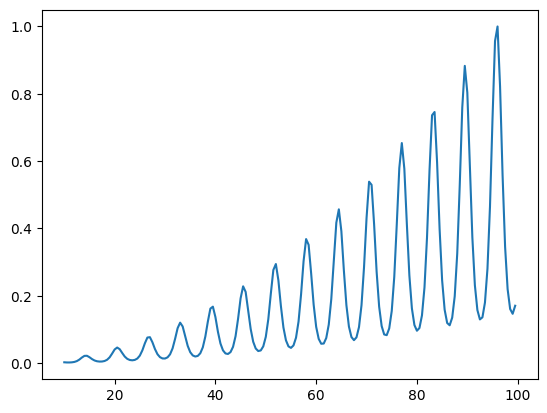

In [76]:
x_min = 10
x_max = 100
x = np.arange(x_min, x_max, 0.5)
x = x.reshape(-1,1)
x = x
y = approximationFunc(x)
y = y.reshape(-1,1)
y = y/np.max(y)

print("Trains")
plt.plot(x,y)
plt.show()

In [77]:
weights = [];
biasWeights = [];
#weights = ReadWeigthFromFile(path);
#biasWeights = ReadWeigthFromFile(pathForBias);
'''
#perceptron = HebbNetworkGradient([1,7,1],biasWeights, weights, eps = 0.001, ruleEps = 0.001, lam=0.01)
#perceptron.fit(x,y)
print("trainLoss: ",perceptron.CalculateLoss(x, y))

test_x = np.arange(x_min, x_max, 0.1)
test_x = test_x.reshape((-1,1))

test_y = approximationFunc(test_x)
test_y  = test_y.reshape((-1,1))
test_y = test_y/np.max(test_y)
print("testLoss: ",perceptron.CalculateLoss(test_x, test_y))
plt.plot(test_x ,test_y )

pred_y = perceptron.predict(test_x)
plt.plot(test_x, pred_y)
plt.show()
SaveWeigthsInFile(path, perceptron)
SaveBiasWeightsInFile(pathForBias, perceptron)
'''


'\n#perceptron = HebbNetworkGradient([1,7,1],biasWeights, weights, eps = 0.001, ruleEps = 0.001, lam=0.01)\n#perceptron.fit(x,y)\nprint("trainLoss: ",perceptron.CalculateLoss(x, y))\n\ntest_x = np.arange(x_min, x_max, 0.1)\ntest_x = test_x.reshape((-1,1))\n\ntest_y = approximationFunc(test_x)\ntest_y  = test_y.reshape((-1,1))\ntest_y = test_y/np.max(test_y)\nprint("testLoss: ",perceptron.CalculateLoss(test_x, test_y))\nplt.plot(test_x ,test_y )\n\npred_y = perceptron.predict(test_x)\nplt.plot(test_x, pred_y)\nplt.show()\nSaveWeigthsInFile(path, perceptron)\nSaveBiasWeightsInFile(pathForBias, perceptron)\n'

In [78]:

class RBF:
    def __init__(self, R = 1) -> None:
        self.R = 1
        self.A = 1/(2 * self.R * self.R)
    
    def fun_act(self, x, r, c):
        return np.exp(-np.square(x - c)/np.square(r))

    def fun_h(self, x,r,c):
        return np.exp(-r*np.abs(x - c))

    def fun_H(self, t_x, t_c, r):
        H = np.zeros((len(t_x), len(t_c)))
        for i in range(len(t_x)):
            for j in range(len(t_c)):
                H[i][j] = self.fun_h(t_x[i], r, t_c[j])
        return H

    def fun_RBN(self, x, t_c, a, w):
        h = np.zeros((len(t_c)))
        for i in range(len(t_c)):
            h[i] = self.fun_h(x, a, t_c[i])
        return np.dot(h,w)

    def fit(self, x, y, c):
        H = self.fun_H(x, c, self.A)
        H_ = np.dot(np.linalg.inv(np.dot(H.transpose(), H)), H.transpose())
        W = np.dot(H_, y)
        self.W = W

    def predict(self, data, c):
        pred_y = np.zeros((len(data)))
        for i in range(len(data)):
            pred_y[i] = self.fun_RBN(data[i], c, self.A, self.W)
        return pred_y
        

In [79]:
test_x = np.arange(x_min, x_max, 0.1)
test_x = test_x.reshape((-1,1))

test_y = approximationFunc(test_x)
test_y  = test_y.reshape((-1,1))
test_y = test_y/np.max(test_y)

In [98]:
perceptron1layer = HebbNetworkGradient([1,7,1], neuroneKnowingRatio=0.5, eps = 0.1, lam=0.001, drawInfo=False)
perceptron1layer.fit(x,y)


New best L: 0.763211695094185
New best L: 0.7403645699903924
New best L: 0.7398963466347371
New best L: 0.7349602831353994
New best L: 0.7347333220726895
New best L: 0.7331495893998754
New best L: 0.730057711307211
New best L: 0.7271534023912574
New best L: 0.7235958405591609
New best L: 0.7233433568605027
New best L: 0.7232737050659719
New best L: 0.7227977983719901
New best L: 0.7200659717809439
New best L: 0.718556620668035
New best L: 0.718085667925855
New best L: 0.7160459000263191
New best L: 0.7156318493862565
New best L: 0.7117470761611098
New best L: 0.7104172369995693
New best L: 0.7067888574925228
New best L: 0.703677372244794
New best L: 0.7032555634199544
New best L: 0.7024670211469052
New best L: 0.7004569080311509
New best L: 0.6990750091186864
New best L: 0.6977588140495873
New best L: 0.6905341896988868
New best L: 0.687364754666727
New best L: 0.6872955917394564
New best L: 0.6871651602363452
New best L: 0.6869903085214037
New best L: 0.6847634275228138
New best L: 0.

KeyboardInterrupt: 

In [86]:
perceptron2layer = HebbNetworkGradient([1,7,7,1], neuroneKnowingRatio=0.3, eps = 0.1, lam=0.001, drawInfo=False)
perceptron2layer.fit(x,y)

New best L: 0.8050776659307887
New best L: 0.801434479185201
New best L: 0.7992165003343814
New best L: 0.7926374885021329
New best L: 0.7925263508780814
New best L: 0.7917310691287501
New best L: 0.7916076896950451
New best L: 0.7827571225387747
New best L: 0.7819181321263806
New best L: 0.7003647182397208
New best L: 0.6889788854595862
New best L: 0.6879038903819631
New best L: 0.6806973825001756
New best L: 0.6803352065009004
New best L: 0.6727349545304415
New best L: 0.650796390178372
New best L: 0.639890399045148
New best L: 0.6271671666191505
New best L: 0.5832884681223954
New best L: 0.5610395735187633


KeyboardInterrupt: 

In [87]:
n = 5
c = np.arange(x_min, x_max, (x_max-x_min)/n)
c = c.reshape(-1,1)
rbf = RBF()
rbf.fit(x, y, c)

In [99]:
perceptron1layer = HebbNetworkGradient([1,7,1], perceptron1layer.BestBiasWeights, perceptron1layer.BestWeights)

1
2


In [88]:
perceptron2layer = HebbNetworkGradient([1,7,7,1], perceptron2layer.BestBiasWeights, perceptron2layer.BestWeights)

1
2
3


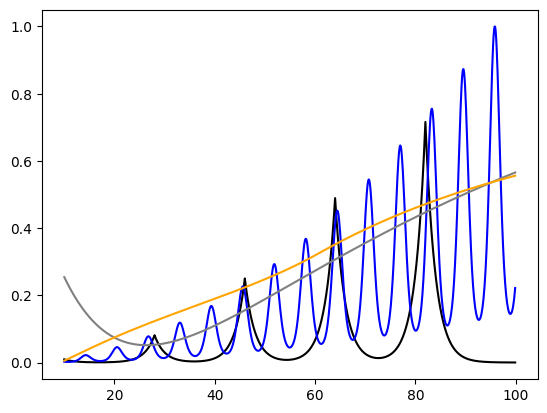

In [100]:
from turtle import color

pred_y_rbf = rbf.predict(test_x,c)
pred_y_perc1 = perceptron1layer.predict(test_x)
pred_y_perc2 = perceptron2layer.predict(test_x)
plt.plot(test_x, pred_y_rbf, color = 'black')
plt.plot(test_x ,test_y , color = 'b')
plt.plot(test_x,pred_y_perc1, color = 'gray')
plt.plot(test_x,pred_y_perc2, color = 'orange')

plt.show()